In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from constants import *
from chronos import Chronos2Pipeline, ChronosBoltPipeline, ChronosPipeline
from time import perf_counter, sleep
import warnings
warnings.filterwarnings('ignore')


print(f"PID: {os.getpid()}")
# sleep(5)


plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (8, 4)


CITY_FILES = {
    CITY_GURGAON: GURGAON_FILE,
    CITY_PATNA: PATNA_FILE,
}
TARGT = "calibPM"
TIMESTAMP = "From Date"

# To keep runtime under control, you can limit number of windows per config
# Set to None for full evaluation
MAX_WINDOWS_PER_CONFIG = 200  # or None


def load_city_df(city_name: str, csv_path: str) -> pd.DataFrame:
    """
    Load a city's CSV and return a DataFrame with columns:
    ["id", "timestamp", "target"], sorted by timestamp.
    """
    df_raw = pd.read_csv(csv_path)

    df = df_raw.iloc[:, [0, 4]].copy()
    df.columns = [TIMESTAMP, TARGT]

    # Parse datetime and sort
    df["timestamp"] = pd.to_datetime(df[TIMESTAMP])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Add Chronos-compatible columns
    df["id"] = city_name
    df = df[["id", "timestamp", TARGT]]
    df = df.rename(columns={TARGT: "target"})

    return df


# Load both cities
city_dfs = {
    city: load_city_df(city, path)
    for city, path in CITY_FILES.items()
}


# Quick sanity check
for city, df in city_dfs.items():
    print(f"{city}: {df['timestamp'].min()} -> {df['timestamp'].max()}, "
          f"{len(df)} rows, freq approx = {(df['timestamp'].diff().mode().iloc[0])}")

d:\Courses\Sem 9\COL851 - Spl OS\project\part1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PID: 14036
Gurgaon: 2024-07-01 00:00:00 -> 2024-12-31 23:00:00, 4416 rows, freq approx = 0 days 01:00:00
Patna: 2024-07-01 00:00:00 -> 2024-12-31 23:00:00, 4416 rows, freq approx = 0 days 01:00:00


In [ ]:
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map="cpu",
    dtype=torch.float32,
)


In [3]:
pipeline = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny",
    device_map="cpu",
    dtype=torch.float32,
)

In [2]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",
    dtype=torch.float32,
)

In [3]:
def evaluate_city_config(
    city_df: pd.DataFrame,
    context_hours: int,
    horizon_hours: int,
    max_windows: int | None = None,
) -> np.ndarray:
    """
    Evaluate Chronos-2 on a single city for given context & horizon.

    city_df: DataFrame with ['id', 'timestamp', 'target'], hourly frequency
    context_hours: how many past hours to use as context
    horizon_hours: how many future hours to forecast
    max_windows: optional cap on number of windows to evaluate (for speed)

    Returns: 1D numpy array of RMSE values (one per window)
    """
    df = city_df.sort_values("timestamp").reset_index(drop=True)
    n = len(df)

    ctx = context_hours
    hz = horizon_hours

    rmse_list: list[float] = []

    # We use an expanding sliding window:
    # context indices: [i-ctx, i)  -> horizon indices: [i, i+hz)
    start_i = ctx
    end_i = n - hz

    for i in range(start_i, end_i):
        # Select context & ground truth slices
        context_slice = df.iloc[i - ctx : i].copy()
        gt_slice = df.iloc[i : i + hz].copy()

        # Call Chronos-2 in dataframe mode (no covariates here)
        pred_df = pipeline.predict_df(
            context_slice,
            prediction_length=hz,
            quantile_levels=[0.1, 0.5, 0.9],
            id_column="id",
            timestamp_column="timestamp",
            target="target",
        )

        # Align predictions with ground-truth timestamps
        ts_pred = (
            pred_df.set_index("timestamp")
            .loc[gt_slice["timestamp"]]
        )
        y_pred = ts_pred["predictions"].to_numpy()
        y_true = gt_slice["target"].to_numpy()

        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        rmse_list.append(rmse)

        if max_windows is not None and len(rmse_list) >= max_windows:
            break

    return np.asarray(rmse_list)



context_results = {city: [] for city in city_dfs}

for city, df in city_dfs.items():
    print(f"\n=== {city.upper()} – context length sweep (horizon = {HORIZON_24H}h) ===")
    for days in CONTEXT_LENGTHS_DAYS:
        ctx_hours = days * 24
        rmses = evaluate_city_config(
            city_df=df,
            context_hours=ctx_hours,
            horizon_hours=HORIZON_24H,
            max_windows=MAX_WINDOWS_PER_CONFIG,
        )
        mean_rmse = float(np.mean(rmses))
        context_results[city].append(mean_rmse)
        print(f"  context = {days:2d} days ({ctx_hours:4d}h): "
              f"avg RMSE = {mean_rmse:.3f} over {len(rmses)} windows")



=== GURGAON – context length sweep (horizon = 24h) ===


KeyboardInterrupt: 

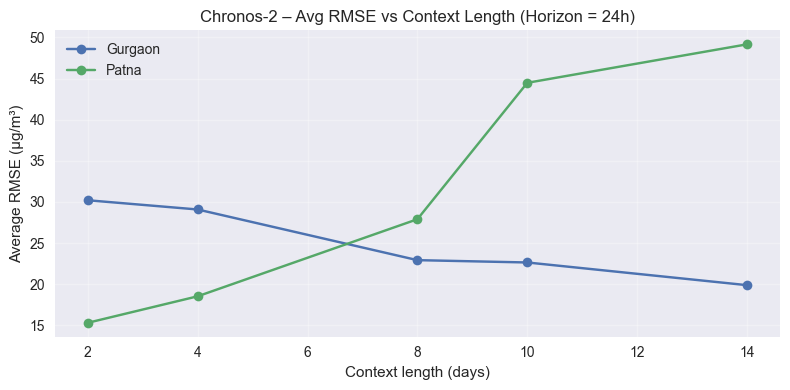

In [5]:
# Plot
plt.figure()
for city, rmse_list in context_results.items():
    plt.plot(CONTEXT_LENGTHS_DAYS, rmse_list, marker="o", label=city.capitalize())

plt.xlabel("Context length (days)")
plt.ylabel("Average RMSE (µg/m³)")
plt.title(f"Chronos-2 – Avg RMSE vs Context Length (Horizon = {HORIZON_24H}h)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
horizon_results = {city: [] for city in city_dfs}
fixed_ctx_hours = CONTEXT_10DAYS_HOURS

for city, df in city_dfs.items():
    print(f"\n=== {city.upper()} – horizon sweep (context = {CONTEXT_10DAYS_HOURS} hours) ===")
    for horizon_hours in FORECAST_HORIZONS_HOURS:
        rmses = evaluate_city_config(
            city_df=df,
            context_hours=fixed_ctx_hours,
            horizon_hours=horizon_hours,
            max_windows=MAX_WINDOWS_PER_CONFIG,
        )
        mean_rmse = float(np.mean(rmses))
        horizon_results[city].append(mean_rmse)
        print(f"  horizon = {horizon_hours:2d}h: "
              f"avg RMSE = {mean_rmse:.3f} over {len(rmses)} windows")


=== GURGAON – horizon sweep (context = 240 hours) ===
  horizon =  4h: avg RMSE = 14.158 over 200 windows
  horizon =  8h: avg RMSE = 17.480 over 200 windows
  horizon = 12h: avg RMSE = 19.289 over 200 windows
  horizon = 24h: avg RMSE = 22.644 over 200 windows
  horizon = 48h: avg RMSE = 25.356 over 200 windows

=== PATNA – horizon sweep (context = 240 hours) ===
  horizon =  4h: avg RMSE = 21.703 over 200 windows
  horizon =  8h: avg RMSE = 30.582 over 200 windows
  horizon = 12h: avg RMSE = 35.764 over 200 windows
  horizon = 24h: avg RMSE = 44.476 over 200 windows
  horizon = 48h: avg RMSE = 57.472 over 200 windows


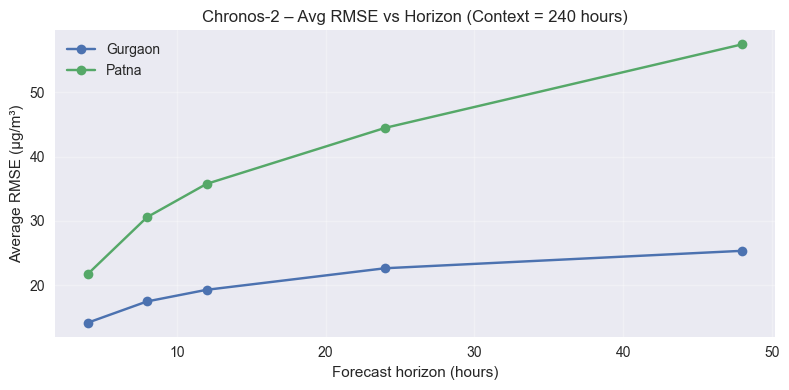

In [7]:
# Plot
plt.figure()
for city, rmse_list in horizon_results.items():
    plt.plot(FORECAST_HORIZONS_HOURS, rmse_list, marker="o", label=city.capitalize())

plt.xlabel("Forecast horizon (hours)")
plt.ylabel("Average RMSE (µg/m³)")
plt.title(f"Chronos-2 – Avg RMSE vs Horizon (Context = {CONTEXT_10DAYS_HOURS} hours)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
for city in city_dfs.keys():
    # Best context for 24h horizon
    ctx_rmse = np.array(context_results[city])
    best_ctx_idx = int(ctx_rmse.argmin())
    best_ctx_days = CONTEXT_LENGTHS_DAYS[best_ctx_idx]

    # Best horizon for 10-day context
    hz_rmse = np.array(horizon_results[city])
    best_hz_idx = int(hz_rmse.argmin())
    best_hz_hours = FORECAST_HORIZONS_HOURS[best_hz_idx]

    print(
        f"{city.capitalize():7s} | best context (24h horizon): "
        f"{best_ctx_days} days (RMSE={ctx_rmse[best_ctx_idx]:.3f}) | "
        f"best horizon (10-day context): "
        f"{best_hz_hours}h (RMSE={hz_rmse[best_hz_idx]:.3f})"
    )

Gurgaon | best context (24h horizon): 14 days (RMSE=19.886) | best horizon (10-day context): 4h (RMSE=14.158)
Patna   | best context (24h horizon): 2 days (RMSE=15.313) | best horizon (10-day context): 4h (RMSE=21.703)


In [ ]:
# Save results to CSV
results_df = pd.DataFrame({
    "context_days": CONTEXT_LENGTHS_DAYS,
    **{f"{city}_rmse": rmse_list for city, rmse_list in context_results.items()},
})
results_df.to_csv("./output/chronos2_context_results.csv", index=False)
results_df = pd.DataFrame({
    "horizon_hours": FORECAST_HORIZONS_HOURS,
    **{f"{city}_rmse": rmse_list for city, rmse_list in horizon_results.items()},
})
results_df.to_csv("./output/chronos2_horizon_results.csv", index=False)

In [4]:
for city in city_dfs.keys():
# check all the csv in output/ directory
    min_context_rmse = float('inf')
    min_horizon_rmse = float('inf')
    best_model_context = ""
    best_model_horizon = ""
    best_horizon_hours = 0
    best_context_days = 0
    for file in os.listdir("./output/"):
        model = file.split('_')[0]
        if file == "extra.txt":
            continue
        df = pd.read_csv(f"./output/{file}")
        if 'context' in file:
            city_rmse_col = f"{city}_rmse"
            min_rmse = df[city_rmse_col].min()
            if min_rmse < min_context_rmse:
                min_context_rmse = min_rmse
                best_model_context = model
                best_context_days = df.loc[df[city_rmse_col] == min_rmse, 'context_days'].values[0]
        elif 'horizon' in file:
            city_rmse_col = f"{city}_rmse"
            min_rmse = df[city_rmse_col].min()
            if min_rmse < min_horizon_rmse:
                min_horizon_rmse = min_rmse
                best_model_horizon = model
                best_horizon_hours = df.loc[df[city_rmse_col] == min_rmse, 'horizon_hours'].values[0]
    print(f"{city.capitalize():7s} | Best Context Model: {best_model_context} | "
          f"Context Days: {best_context_days} | Min RMSE: {min_context_rmse:.3f} || "
          f"Best Horizon Model: {best_model_horizon} | "
            f"Horizon Hours: {best_horizon_hours} | Min RMSE: {min_horizon_rmse:.3f}")

Gurgaon | Best Context Model: chronos-2 | Context Days: 8 | Min RMSE: 49.609 || Best Horizon Model: chronos-t5-small | Horizon Hours: 4 | Min RMSE: 24.786
Patna   | Best Context Model: chronos-2 | Context Days: 8 | Min RMSE: 39.112 || Best Horizon Model: chronos-2 | Horizon Hours: 4 | Min RMSE: 22.369
